In [7]:
from modules.shared.globals import *
from modules.training.cme_modeling import ModelBuilder
from modules.training.ts_modeling import (
    build_dataset,
    stratified_split,
    set_seed)

mb = ModelBuilder()

In [ ]:
seed = SEEDS[0]
inputs_to_use = INPUTS_TO_USE[0]
add_slope = ADD_SLOPE[0]
cme_speed_threshold = CME_SPEED_THRESHOLD[0]
outputs_to_use = OUTPUTS_TO_USE

set_seed(seed)

# set the root directory
# root_dir_laptop = 'C:/Users/the_3/Documents/github/keras-functional-api/data/electron_cme_data_split_v7'
root_dir = 'D:/College/Fall2023/sep-forecasting-research/data/electron_cme_data_split_v7'
# build the dataset
X_train, y_train = build_dataset(
    root_dir + '/training',
    inputs_to_use=inputs_to_use,
    add_slope=add_slope,
    outputs_to_use=outputs_to_use,
    cme_speed_threshold=cme_speed_threshold,
    shuffle_data=True)

X_test, y_test = build_dataset(
    root_dir + '/testing',
    inputs_to_use=inputs_to_use,
    add_slope=add_slope,
    outputs_to_use=outputs_to_use,
    cme_speed_threshold=cme_speed_threshold)

X_subtrain, y_subtrain, X_val, y_val = stratified_split(X_train, y_train, seed=seed, debug=True)

# print all cme_files shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')



In [5]:
from modules.training.ts_modeling import stratified_4fold_split


In [ ]:
for i, (X_subtrain, y_subtrain, X_val, y_val) in enumerate(stratified_4fold_split(X_train, y_train, seed=seed, debug=True)):
    print(f'Fold {i + 1}:')
    print(f'X_subtrain.shape: {X_subtrain.shape}')
    print(f'y_subtrain.shape: {y_subtrain.shape}')
    print(f'X_val.shape: {X_val.shape}')
    print(f'y_val.shape: {y_val.shape}')

In [14]:
from scipy.spatial.distance import jensenshannon
import numpy as np
from typing import Dict, Union


def calculate_js_divergence(X1: np.ndarray, X2: np.ndarray) -> Dict[str, float]:
    """
    Calculate the Jensen-Shannon (JS) divergence for each feature between two datasets.

    Args:
        X1 (np.ndarray): The first dataset (e.g., training data) with shape (n_samples, n_features).
        X2 (np.ndarray): The second dataset (e.g., test data) with shape (n_samples, n_features).

    Returns:
        Dict[str, float]: A dictionary where the keys are feature names (or indices) 
                          and the values are the corresponding JS divergence values.
    """
    js_divergences = {}
    n_features = X1.shape[1]  # Number of features

    # Iterate over each feature index
    for i in range(n_features):
        # Create a histogram for the feature in each dataset
        p = np.histogram(X1[:, i], bins=100, density=True)[0]
        q = np.histogram(X2[:, i], bins=100, density=True)[0]

        # Calculate the JS divergence between the two histograms
        js_div = jensenshannon(p, q)

        # Store the JS divergence in the dictionary with the feature index as the key
        js_divergences[f'Feature_{i}'] = js_div

    return js_divergences


import matplotlib.pyplot as plt


def calculate_js_divergence_labels(y1: Union[np.ndarray, list], y2: Union[np.ndarray, list], bin_width: float = 0.1,
                                   plot: bool = False) -> float:
    """
    Calculate the Jensen-Shannon (JS) divergence between the label distributions of two regression datasets.
    Optionally, plot the histograms of the label distributions.

    Args:
        y1 (Union[np.ndarray, list]): The labels for the first dataset (e.g., training labels).
        y2 (Union[np.ndarray, list]): The labels for the second dataset (e.g., test labels).
        plot (bool): If True, plot the histograms of the label distributions. Default is False.

    Returns:
        float: The JS divergence between the label distributions.
    """
    # Define the bin edges for the histograms with width 0.1 between -2.5 and 2.5
    bins = np.arange(-2.5, 2.5 + bin_width, bin_width)

    # Calculate histograms for the labels with the same bins for both datasets
    p = np.histogram(y1, bins=bins, density=True)[0]
    q = np.histogram(y2, bins=bins, density=True)[0]

    # Calculate the JS divergence between the two label distributions
    js_div = jensenshannon(p, q)

    # Plot the histograms if requested
    if plot:
        plt.figure(figsize=(10, 6))

        # Plot the histogram for the first dataset
        plt.hist(y1, bins=bins, density=True, alpha=0.5, color='blue', label='Dataset 1 (y1)')

        # Plot the histogram for the second dataset
        plt.hist(y2, bins=bins, density=True, alpha=0.5, color='orange', label='Dataset 2 (y2)')

        # Adding labels and title
        plt.xlabel('Label Value')
        plt.ylabel('Density')
        plt.title('Label Distribution Comparison')
        plt.legend(loc='upper right')

        # Show the plot
        plt.show()

    return js_div

In [ ]:
# Calculate JS divergence for features
js_train_test = calculate_js_divergence(X_train, X_test)
js_subtrain_test = calculate_js_divergence(X_subtrain, X_test)
js_val_test = calculate_js_divergence(X_val, X_test)

# Calculate JS divergence for labels
js_labels_train_test = calculate_js_divergence_labels(y_train, y_test, bin_width=0.01, plot=True)
js_labels_subtrain_test = calculate_js_divergence_labels(y_subtrain, y_test, bin_width=0.01, plot=True)
js_labels_val_test = calculate_js_divergence_labels(y_val, y_test, bin_width=0.01, plot=True)

# Print all JS divergences for features
print(f'Seed: {seed}, Inputs: {inputs_to_use}, Add Slope: {add_slope}, CME Speed Threshold: {cme_speed_threshold}')
print('JS Divergence between X_train and X_test:')
for feature, js_div in js_train_test.items():
    print(f'Feature: {feature}, JS Divergence: {js_div:.4f}')

print('JS Divergence between X_subtrain and X_test:')
for feature, js_div in js_subtrain_test.items():
    print(f'Feature: {feature}, JS Divergence: {js_div:.4f}')

print('JS Divergence between X_val and X_test:')
for feature, js_div in js_val_test.items():
    print(f'Feature: {feature}, JS Divergence: {js_div:.4f}')

# Print average JS divergences for features
avg_js_train_test = np.mean(list(js_train_test.values()))
avg_js_subtrain_test = np.mean(list(js_subtrain_test.values()))
avg_js_val_test = np.mean(list(js_val_test.values()))
print(f'Average JS Divergence between X_train and X_test: {avg_js_train_test:.4f}')
print(f'Average JS Divergence between X_subtrain and X_test: {avg_js_subtrain_test:.4f}')
print(f'Average JS Divergence between X_val and X_test: {avg_js_val_test:.4f}')

# Print JS divergences for labels
print(f'JS Divergence between y_train and y_test: {js_labels_train_test:.4f}')
print(f'JS Divergence between y_subtrain and y_test: {js_labels_subtrain_test:.4f}')
print(f'JS Divergence between y_val and y_test: {js_labels_val_test:.4f}')

### Summary: Jensen-Shannon (JS) Divergence

- **JS Divergence**: Measures the similarity between two probability distributions.
- **Range**: 0 (identical) to 1 (completely dissimilar).
- **Good Value**: JS close to 0 indicates similar distributions.
- **Bad Value**: JS close to 1 indicates significant differences.

### Results for Your Dataset

- **y_train vs. y_test**: JS = 0.0861
- **y_subtrain vs. y_test**: JS = 0.0867
- **y_val vs. y_test**: JS = 0.0943

These relatively low JS values suggest that the label distributions in your training, subtraining, validation, and test sets are quite similar. While the divergences are not negligible, they are still well within a range that generally indicates good distributional alignment. This implies that your model should be able to generalize well across these datasets, with minimal risk of performance degradation due to distributional differences.

In [16]:
def calculate_js_divergence_labels_subset(y1: Union[np.ndarray, list], y2: Union[np.ndarray, list],
                                          bin_width: float = 0.1, lower_b: float = -2.5,
                                          higher_b: float = 2.5, plot: bool = False) -> float:
    """
    Calculate the Jensen-Shannon (JS) divergence between the label distributions of two regression datasets
    within a specified subset range. Optionally, plot the histograms of the label distributions.

    Args:
        y1 (Union[np.ndarray, list]): The labels for the first dataset (e.g., training labels).
        y2 (Union[np.ndarray, list]): The labels for the second dataset (e.g., test labels).
        bin_width (float): The width of the bins for the histograms. Default is 0.1.
        lower_b (float): The lower bound of the subset range to consider. Default is -2.5.
        higher_b (float): The upper bound of the subset range to consider. Default is 2.5.
        plot (bool): If True, plot the histograms of the label distributions. Default is False.

    Returns:
        float: The JS divergence between the label distributions within the specified range.
    """
    # Filter the data to consider only the subset within the specified range
    y1_subset = np.array([y for y in y1 if lower_b <= y <= higher_b])
    y2_subset = np.array([y for y in y2 if lower_b <= y <= higher_b])

    # Define the bin edges for the histograms with the specified bin width within the given range
    bins = np.arange(lower_b, higher_b + bin_width, bin_width)

    # Calculate histograms for the labels with the same bins for both datasets
    p = np.histogram(y1_subset, bins=bins, density=True)[0]
    q = np.histogram(y2_subset, bins=bins, density=True)[0]

    # Calculate the JS divergence between the two label distributions
    js_div = jensenshannon(p, q)

    # Plot the histograms if requested
    if plot:
        plt.figure(figsize=(10, 6))

        # Plot the histogram for the first dataset
        plt.hist(y1_subset, bins=bins, density=True, alpha=0.5, color='blue', label='Dataset 1 (y1)')

        # Plot the histogram for the second dataset
        plt.hist(y2_subset, bins=bins, density=True, alpha=0.5, color='orange', label='Dataset 2 (y2)')

        # Adding labels and title
        plt.xlabel('Label Value')
        plt.ylabel('Density')
        plt.title(f'Label Distribution Comparison (Subset between {lower_b} and {higher_b})')
        plt.legend(loc='upper right')

        # Show the plot
        plt.show()

    return js_div

In [ ]:
lower_bound = 0.5
upper_bound = 2.5

# Calculate JS divergence for labels within the subset range
js_labels_train_test_subset = calculate_js_divergence_labels_subset(y_train, y_test, lower_b=lower_bound,
                                                                    higher_b=upper_bound, bin_width=0.01, plot=True)
js_labels_subtrain_test_subset = calculate_js_divergence_labels_subset(y_subtrain, y_test, lower_b=lower_bound,
                                                                       higher_b=upper_bound, bin_width=0.01, plot=True)
js_labels_val_test_subset = calculate_js_divergence_labels_subset(y_val, y_test, lower_b=lower_bound,
                                                                  higher_b=upper_bound, bin_width=0.01, plot=True)

# Print JS divergences for labels within the subset range
print(
    f'JS Divergence between y_train and y_test (Subset between {lower_bound} and {upper_bound}): {js_labels_train_test_subset:.4f}')
print(
    f'JS Divergence between y_subtrain and y_test (Subset between {lower_bound} and {upper_bound}): {js_labels_subtrain_test_subset:.4f}')
print(
    f'JS Divergence between y_val and y_test (Subset between {lower_bound} and {upper_bound}): {js_labels_val_test_subset:.4f}')

In [ ]:
lower_bound = 0.5
upper_bound = 2.5

# Calculate JS divergence for labels within the subset range
# js_labels_train_test_subset = calculate_js_divergence_labels_subset(y_train, y_test, lower_b=lower_bound,
#                                                                     higher_b=upper_bound, bin_width=0.01, plot=True)
# js_labels_subtrain_test_subset = calculate_js_divergence_labels_subset(y_subtrain, y_test, lower_b=lower_bound,
#                                                                        higher_b=upper_bound, bin_width=0.01, plot=True)
js_labels_val_test_subset = calculate_js_divergence_labels_subset(y_val, y_train, lower_b=lower_bound,
                                                                  higher_b=upper_bound, bin_width=0.1, plot=True)


# Print JS divergences for labels within the subset range
# print(
#     f'JS Divergence between y_train and y_test (Subset between {lower_bound} and {upper_bound}): {js_labels_train_test_subset:.4f}')
# print(
#     f'JS Divergence between y_subtrain and y_test (Subset between {lower_bound} and {upper_bound}): {js_labels_subtrain_test_subset:.4f}')
print(
    f'JS Divergence between y_val and y_train (Subset between {lower_bound} and {upper_bound}): {js_labels_val_test_subset:.4f}')

In [ ]:
lower_bound = -2.5
upper_bound = 2.5

# Calculate JS divergence for labels within the subset range
# js_labels_train_test_subset = calculate_js_divergence_labels_subset(y_train, y_test, lower_b=lower_bound,
#                                                                     higher_b=upper_bound, bin_width=0.01, plot=True)
# js_labels_subtrain_test_subset = calculate_js_divergence_labels_subset(y_subtrain, y_test, lower_b=lower_bound,
#                                                                        higher_b=upper_bound, bin_width=0.01, plot=True)
js_labels_val_test_subset = calculate_js_divergence_labels_subset(y_val, y_train, lower_b=lower_bound,
                                                                  higher_b=upper_bound, bin_width=0.01, plot=True)


# Print JS divergences for labels within the subset range
# print(
#     f'JS Divergence between y_train and y_test (Subset between {lower_bound} and {upper_bound}): {js_labels_train_test_subset:.4f}')
# print(
#     f'JS Divergence between y_subtrain and y_test (Subset between {lower_bound} and {upper_bound}): {js_labels_subtrain_test_subset:.4f}')
print(
    f'JS Divergence between y_val and y_train (Subset between {lower_bound} and {upper_bound}): {js_labels_val_test_subset:.4f}')

### Analysis of JS Divergence for the Subset between 0.5 and 2.5

- **JS Divergence between `y_train` and `y_test` (Subset 0.5 to 2.5): 0.4015**
- **JS Divergence between `y_subtrain` and `y_test` (Subset 0.5 to 2.5): 0.3993**
- **JS Divergence between `y_val` and `y_test` (Subset 0.5 to 2.5): 0.5027**

### Interpretation:

- **Higher JS Divergence**:
  - These JS divergence values are notably higher than those observed for the full dataset range. Specifically, the divergence values range from approximately 0.4 to 0.5.
  - **0.4015** and **0.3993** indicate a moderate difference between the training, subtraining, and test label distributions.
  - **0.5027** is quite high, particularly for the validation set compared to the test set, suggesting a more significant difference in this subset range.

### Implications:

- **Potential Distributional Shift**: The higher JS divergence in this specific range (0.5 to 2.5) suggests that there is a notable difference in how the labels are distributed in this region between your training, subtraining, validation, and test sets. This could indicate a distributional shift, particularly in the validation set, that may affect model performance in this range.
- **Impact on Model Performance**:
  - If this range (0.5 to 2.5) is particularly important for your prediction task, the model might struggle to generalize well in this interval due to the distributional differences.
  - The validation set having the highest divergence (**0.5027**) compared to the test set could lead to validation performance not accurately reflecting the test performance.

#

In [ ]:
lower_bound = -2.5
higher_bound = -0.5

# Calculate JS divergence for labels within the subset range
js_labels_train_test_subset = calculate_js_divergence_labels_subset(y_train, y_test, lower_b=lower_bound,
                                                                    higher_b=higher_bound, bin_width=0.01, plot=True)
js_labels_subtrain_test_subset = calculate_js_divergence_labels_subset(y_subtrain, y_test, lower_b=lower_bound,
                                                                       higher_b=higher_bound, bin_width=0.01, plot=True)
js_labels_val_test_subset = calculate_js_divergence_labels_subset(y_val, y_test, lower_b=lower_bound,
                                                                    higher_b=higher_bound, bin_width=0.01, plot=True)

# Print JS divergences for labels within the subset range
print(
    f'JS Divergence between y_train and y_test (Subset between {lower_bound} and {higher_bound}): {js_labels_train_test_subset:.4f}')
print(
    f'JS Divergence between y_subtrain and y_test (Subset between {lower_bound} and {higher_bound}): {js_labels_subtrain_test_subset:.4f}')
print(
    f'JS Divergence between y_val and y_test (Subset between {lower_bound} and {higher_bound}): {js_labels_val_test_subset:.4f}')



### Analysis of JS Divergence for the Subset between -2.5 and -0.5

- **JS Divergence between `y_train` and `y_test` (Subset -2.5 to -0.5): 0.4991**
- **JS Divergence between `y_subtrain` and `y_test` (Subset -2.5 to -0.5): 0.5104**
- **JS Divergence between `y_val` and `y_test` (Subset -2.5 to -0.5): 0.5238**

### Interpretation:

- **High JS Divergence**:
  - These JS divergence values are quite high, close to or exceeding 0.5, which indicates significant differences in the label distributions between your datasets in the subset range from -2.5 to -0.5.
  - **0.4991** for `y_train` vs. `y_test` and **0.5104** for `y_subtrain` vs. `y_test` suggest that the training and subtraining sets differ notably from the test set in this range.
  - **0.5238** for `y_val` vs. `y_test` is the highest, indicating that the validation set is particularly different from the test set in this range.

### Implications:

- **Significant Distributional Shift**: The JS divergence values above 0.5 suggest that there is a substantial shift in label distributions between your datasets in the interval from -2.5 to -0.5. This is a strong indicator that the model trained on these data might not generalize well to the test set, especially in this specific range.
- **Model Performance Concerns**:
  - The model's performance in the range from -2.5 to -0.5 could be severely affected due to these high divergence values. Predictions in this region might be less accurate, as the training and validation sets do not represent the test set well in this interval.
  - The highest divergence in the validation set (**0.5238**) suggests that validation performance may not be a reliable indicator of test performance in this range, potentially leading to over- or under-estimation of the model's capability.

# Debugging of stratified batch sampling

In [10]:
from modules.training.ts_modeling import stratified_groups, stratified_data_generator, stratified_batch_dataset

In [11]:
val_groups = stratified_groups(y_val, batch_size=4096)

In [ ]:
# print the size of the whole groups and each group
print(f'Shape of the whole groups: {val_groups.shape}')
print(f'Total number of groups: {len(val_groups)}')
print(f'Sizes of each group: {[len(group) for group in val_groups]}')

In [ ]:
# print the first 5 elements of each group
for i, group in enumerate(val_groups):
    print(f'Group {i}: {group[:5]}')

In [ ]:
# print last 5 elements of each group
for i, group in enumerate(val_groups):
    print(f'Group {i}: {group[-5:]}')

In [15]:
# get the first batch of the stratified data generator
strat_gen = stratified_data_generator(X_val, y_val, groups=val_groups, debug=True)

In [ ]:
X_batch, y_batch = next(strat_gen)

In [ ]:
# print min and max y in batch
import numpy as np
print(f'Min y in batch: {np.min(y_batch)}')
print(f'Max y in batch: {np.max(y_batch)}')

## checking if the peak delta and peak intensity are correlated

In [1]:
root_dir = 'C:/Users/the_3/Documents/github/keras-functional-api/data/electron_cme_data_split_v7/full'

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_peak_values(directory_path: str) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Extract peak values from proton intensity data files in a directory.
    
    This function processes CSV files containing proton intensity data and extracts:
    - Peak log-transformed proton intensity values
    - Peak delta log intensity values 
    - Event IDs
    
    Args:
        directory_path (str): Path to directory containing proton intensity CSV files
        
    Returns:
        tuple: Contains three numpy arrays (all sorted by event ID):
            - peak_log_intensity_array: Array of peak log-transformed proton intensities
            - peak_delta_array: Array of peak delta log intensities
            - event_indices_array: Array of event IDs
    """
    # Initialize lists to store peak values and event IDs
    peak_log_intensity_list = []
    peak_delta_list = []
    event_indices = []

    # Get list of files ending with '_ie_trim.csv'
    # These files contain the proton intensity data for each event
    file_names = [f for f in os.listdir(directory_path) if f.endswith('_ie_trim.csv')]

    for file_name in file_names:
        # Construct full file path and read CSV
        file_path = os.path.join(directory_path, file_name)
        data = pd.read_csv(file_path)

        # Extract relevant columns from the data
        proton_intensity = data['Proton Intensity']
        delta_log_intensity = data['delta_log_Intensity']
        
        # Get event ID from first row (assumed constant throughout file)
        event_id = data['Event ID'].iloc[0]

        # Transform proton intensity using log1p (log(1+x))
        # This helps handle small values and maintains non-negativity
        log_proton_intensity = np.log1p(proton_intensity)

        # Calculate peak values for this event
        peak_log_intensity = log_proton_intensity.max()
        peak_delta = delta_log_intensity.max()

        # Store values for this event
        peak_log_intensity_list.append(peak_log_intensity)
        peak_delta_list.append(peak_delta)
        event_indices.append(event_id)

    # Convert lists to numpy arrays for efficient processing
    peak_log_intensity_array = np.array(peak_log_intensity_list)
    peak_delta_array = np.array(peak_delta_list)
    event_indices_array = np.array(event_indices)

    # Sort all arrays based on event IDs to ensure consistent ordering
    sorted_indices = np.argsort(event_indices_array)
    peak_log_intensity_array = peak_log_intensity_array[sorted_indices]
    peak_delta_array = peak_delta_array[sorted_indices]
    event_indices_array = event_indices_array[sorted_indices]

    return peak_log_intensity_array, peak_delta_array, event_indices_array

In [4]:
def normalize_array(arr: np.ndarray) -> np.ndarray:
    """
    Normalize an array to the range [0,1] using min-max normalization.
    
    Args:
        arr (np.ndarray): Input array to normalize
        
    Returns:
        np.ndarray: Normalized array with values scaled to [0,1]
    """
    # Calculate min and max once to avoid repeated computation
    arr_min = arr.min()
    arr_max = arr.max()
    
    # Normalize using min-max scaling formula: (x - min)/(max - min)
    return (arr - arr_min) / (arr_max - arr_min)

In [10]:
def plot_peak_values(peak_log_intensity: np.ndarray, 
                     peak_delta: np.ndarray, 
                     event_indices: np.ndarray,
                     event_color: bool = False,
                     norm_axis: bool = True) -> None:
    """
    Create a scatter plot comparing peak log proton intensity vs peak delta values.
    
    Args:
        peak_log_intensity (np.ndarray): Array of peak log proton intensity values
        peak_delta (np.ndarray): Array of peak delta values 
        event_indices (np.ndarray): Array of event indices used for coloring the scatter points
        event_color (bool): Whether to color points by event index (default False)
        norm_axis (bool): Whether to normalize the axis values to [0,1] range (default True)
        
    Returns:
        None: Displays the plot using plt.show()
    """
    # Normalize arrays if requested
    x_values = normalize_array(peak_log_intensity) if norm_axis else peak_log_intensity
    y_values = normalize_array(peak_delta) if norm_axis else peak_delta

    # Create figure with reasonable size for visualization
    plt.figure(figsize=(8, 6))
    
    # Create scatter plot with optional event index coloring
    if event_color:
        scatter = plt.scatter(x_values, y_values, 
                            c=event_indices, cmap='viridis')
        # Add colorbar to show event index scale
        plt.colorbar(scatter, label='Event Index')
    else:
        plt.scatter(x_values, y_values)
    
    # Add diagonal reference line if normalized
    if norm_axis:
        plt.plot([0,1], [0,1], linestyle='--', color='gray')
    
    # Label axes and title
    x_label = 'Normalized ' if norm_axis else ''
    y_label = 'Normalized ' if norm_axis else ''
    plt.xlabel(f'{x_label}Peak Log Proton Intensity')
    plt.ylabel(f'{y_label}Peak Delta')
    plt.title('Peak Log Proton Intensity vs Peak Delta')
    
    # Add grid for better readability
    plt.grid(True)
    
    # Display the plot
    plt.show()


Event Index | Peak Log Intensity | Peak Delta
---------------------------------------------
     1      |      0.8633       |   0.4981  
     2      |      1.4888       |   0.8116  
     3      |      0.6465       |   0.2038  
     4      |      1.1481       |   0.3511  
     5      |      3.0664       |   1.0373  
     6      |      0.9555       |   0.4715  
     7      |      0.9908       |   0.1118  
     8      |      0.6270       |   0.4488  
     9      |      1.9021       |   0.7260  
    10      |      5.4397       |   1.3985  
    11      |      4.0879       |   1.0971  
    12      |      5.8718       |   1.7164  
    13      |      3.7559       |   1.7283  
    14      |      1.0618       |   0.3314  
    15      |      0.6609       |   0.2836  
    16      |      1.2592       |   0.7146  
    17      |      0.7221       |   0.3928  
    18      |      0.3363       |   0.0724  
    19      |      2.3955       |   1.0449  
    20      |      2.3292       |   1.4242  
    21 

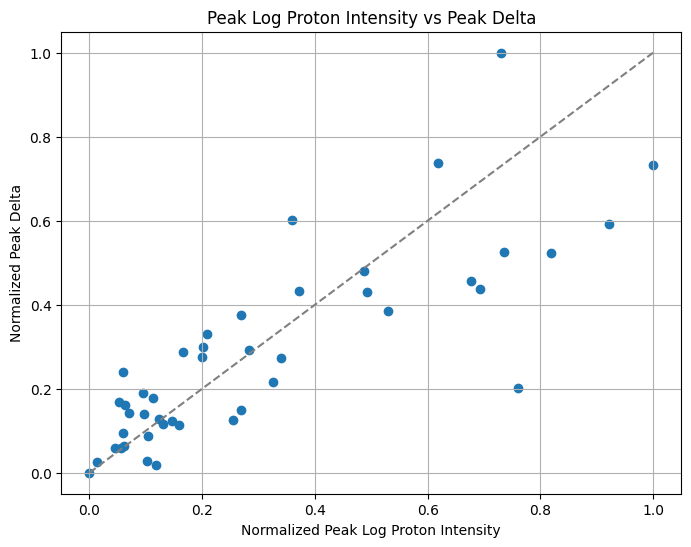

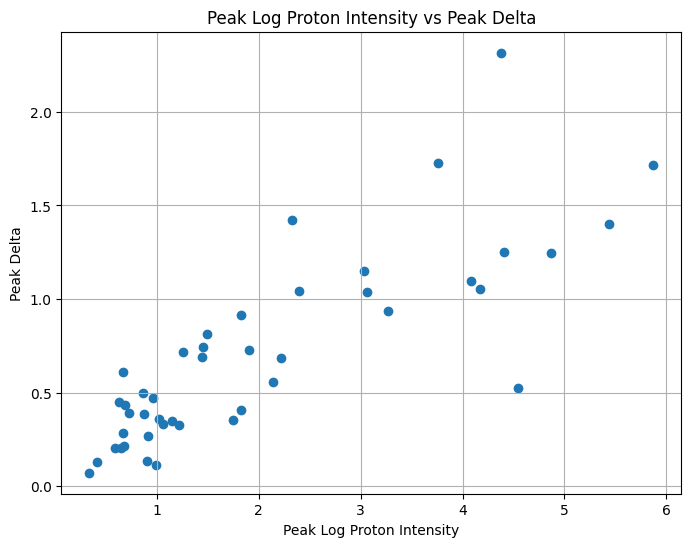

In [11]:
# Usage example
directory_path = root_dir
peak_log_intensity_array, peak_delta_array, event_indices_array = get_peak_values(directory_path)
print("\nEvent Index | Peak Log Intensity | Peak Delta")
print("-" * 45)
for i, (intensity, delta, event) in enumerate(zip(peak_log_intensity_array, peak_delta_array, event_indices_array)):
    print(f"{event:^11d} | {intensity:^17.4f} | {delta:^10.4f}")

plot_peak_values(peak_log_intensity_array, peak_delta_array, event_indices_array)

# Plot unnormalized version
plot_peak_values(peak_log_intensity_array, peak_delta_array, event_indices_array, norm_axis=False)

